# Load in data (documents)

In [2]:
import os
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
import string
from nltk.stem import PorterStemmer
import zipfile

nltk.download('punkt')  # for tokenizing

# Unzipping the files
def unzip_file(zip_path, extract_to):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)

# Unzip the training and test data
unzip_file("/content/master data-ReutersC50_C50train.zip", "/content/master_data_train")
unzip_file("/content/master data-ReutersC50_C50test.zip", "/content/master_data_test")

# Helper function to read data from a labeled directory
def read_data_from_directory(directory_path):
    authors = os.listdir(directory_path)
    texts = []
    labels = []
    for author in authors:
        author_path = os.path.join(directory_path, author)
        for file_name in os.listdir(author_path):
            file_path = os.path.join(author_path, file_name)
            with open(file_path, 'r', encoding='utf-8') as f:
                texts.append(f.read())
                labels.append(author)
    return texts, labels

# Reading the training and test data
train_texts, train_labels = read_data_from_directory("/content/master_data_train")
test_texts, test_labels = read_data_from_directory("/content/master_data_test")


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
# an example of tokenizing a text
word_tokenize(train_texts[0])

# Preprocessing and Info Regarding Train/Test Data

## Preprocessing

In [3]:
# Helper function to tokenize, remove punctuation, and stem
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    # Tokenize
    tokens = word_tokenize(text.lower())

    # Remove punctuation and stop words from token
    tokens = [token for token in tokens if token not in string.punctuation and token not in stop_words]

    # Stemming
    stemmer = PorterStemmer()
    stemmed_tokens = [stemmer.stem(token) for token in tokens]

    return stemmed_tokens

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## General info

In [13]:
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

# Basic Statistics
print(f"Total number of training documents: {len(train_texts)}")
print(f"Total number of test documents: {len(test_texts)}")

train_doc_lengths = [len(preprocess_text(text)) for text in train_texts]
test_doc_lengths = [len(preprocess_text(text)) for text in test_texts]

print(f"\nAverage document length in training set: {np.mean(train_doc_lengths)} words")
print(f"Minimum document length in training set: {np.min(train_doc_lengths)} words")
print(f"Maximum document length in training set: {np.max(train_doc_lengths)} words")
print(f"\nAverage document length in test set: {np.mean(test_doc_lengths)} words")
print(f"Minimum document length in test set: {np.min(test_doc_lengths)} words")
print(f"Maximum document length in test set: {np.max(test_doc_lengths)} words")


Total number of training documents: 2500
Total number of test documents: 2500

Average document length in training set: 328.4308 words
Minimum document length in training set: 33 words
Maximum document length in training set: 957 words

Average document length in test set: 333.2564 words
Minimum document length in test set: 42 words
Maximum document length in test set: 934 words



Most common words across the training set:
said: 19856
's: 14872
'': 13882
``: 13712
year: 6146
compani: 5651
would: 5237
percent: 5211
million: 4942
market: 4629


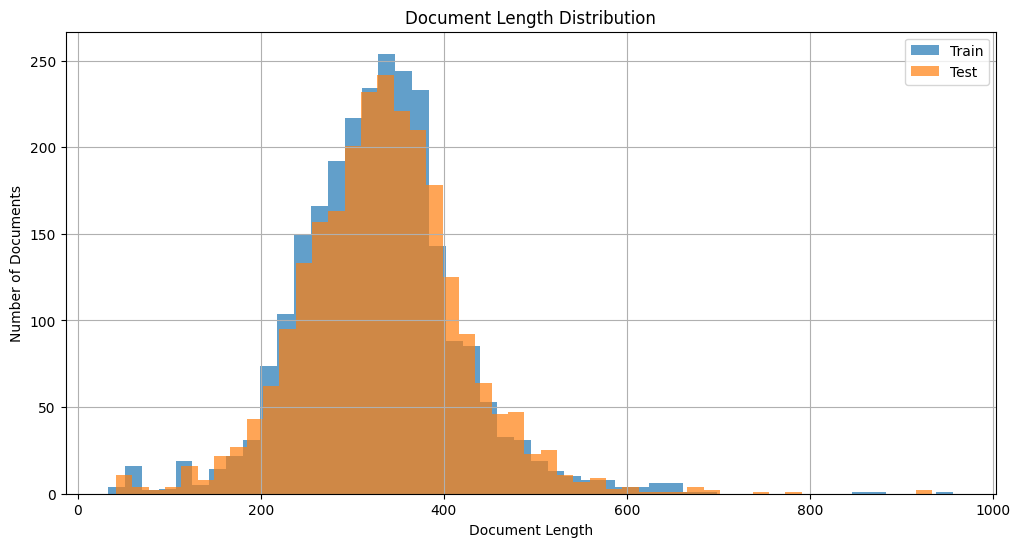

In [14]:
# Term Frequencies
all_tokens = [token for text in train_texts for token in preprocess_text(text)]
common_tokens = Counter(all_tokens).most_common(10) # counter is a class which counts frequencies of each word
print("\nMost common words across the training set:")
for token, freq in common_tokens:
    print(f"{token}: {freq}")

# Document Length Distribution
plt.figure(figsize=(12, 6))
plt.hist(train_doc_lengths, bins=50, alpha=0.7, label='Train')
plt.hist(test_doc_lengths, bins=50, alpha=0.7, label='Test')
plt.title('Document Length Distribution')
plt.xlabel('Document Length')
plt.ylabel('Number of Documents')
plt.legend()
plt.grid(True)
plt.show()


# Convert to TD-IDF

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Step 1: Preprocessing and Vectorization
# Preprocess the text using the preprocess_text function
preprocessed_train_texts = [' '.join(preprocess_text(text)) for text in train_texts]
preprocessed_test_texts = [' '.join(preprocess_text(text)) for text in test_texts]

# Convert the preprocessed text into TF-IDF vectors
vectorizer = TfidfVectorizer(max_features=2500)  # You can adjust the max_features based on your needs
train_dtm = vectorizer.fit_transform(preprocessed_train_texts)
test_dtm = vectorizer.transform(preprocessed_test_texts)

# At this point, train_dtm is a sparse matrix that you can use for clustering


# Hierarchical Clustering

## Hierarchical Clustering code:

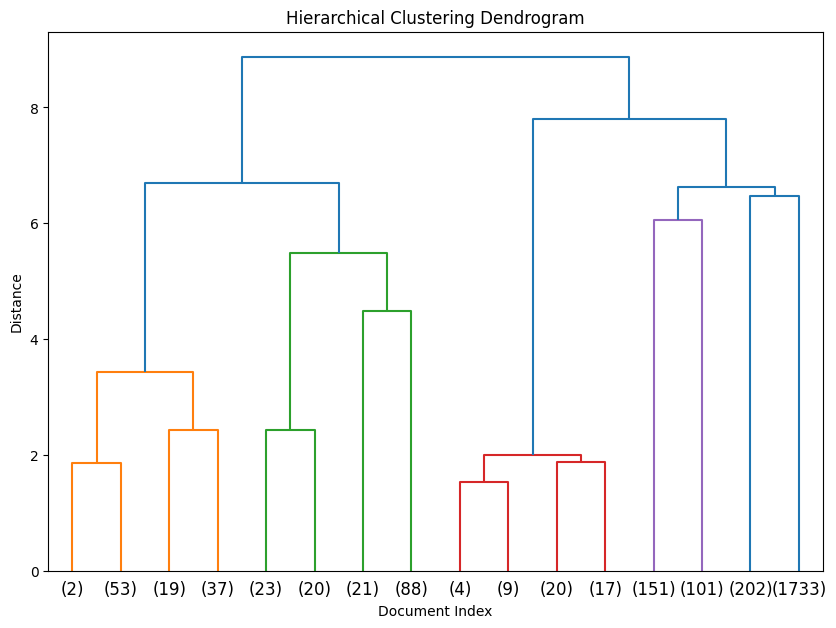

In [5]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

# Step 2: Applying Hierarchical Clustering
# Perform hierarchical clustering using AgglomerativeClustering
# Linkage method 'ward' minimizes the variance within each cluster.
agg_clustering = AgglomerativeClustering(n_clusters=None, distance_threshold=0, linkage='ward')
agg_clustering.fit(train_dtm.toarray())  # Convert the sparse matrix to dense for this step

# Generate the linkage matrix for plotting the dendrogram
Z = linkage(train_dtm.toarray(), method='ward')

# Plotting the dendrogram
plt.figure(figsize=(10, 7))
plt.title('Hierarchical Clustering Dendrogram')
dendrogram(Z, truncate_mode='level', p=3)  # 'truncate_mode' controls how many levels to show
plt.xlabel('Document Index')
plt.ylabel('Distance')
plt.show()


## Where to cut

In [22]:
from scipy.cluster.hierarchy import fcluster

# Cut the dendrogram at a height that corresponds to the number of desired clusters
cluster_labels = fcluster(Z, t=3, criterion='distance')

# Analyze clusters
num_clusters = len(set(cluster_labels))  # This gives you the number of clusters formed


## Num of documents in cluster

In [23]:
import numpy as np

for cluster_num in range(1, num_clusters + 1):
    cluster_indices = np.where(cluster_labels == cluster_num)[0]
    cluster_docs = [train_texts[i] for i in cluster_indices]
    print(f"Cluster {cluster_num} has {len(cluster_docs)} documents.")

    # You can now analyze these documents, find common terms, or even print some of them.


Cluster 1 has 55 documents.
Cluster 2 has 56 documents.
Cluster 3 has 43 documents.
Cluster 4 has 21 documents.
Cluster 5 has 16 documents.
Cluster 6 has 72 documents.
Cluster 7 has 50 documents.
Cluster 8 has 46 documents.
Cluster 9 has 8 documents.
Cluster 10 has 97 documents.
Cluster 11 has 22 documents.
Cluster 12 has 46 documents.
Cluster 13 has 33 documents.
Cluster 14 has 24 documents.
Cluster 15 has 14 documents.
Cluster 16 has 12 documents.
Cluster 17 has 51 documents.
Cluster 18 has 57 documents.
Cluster 19 has 44 documents.
Cluster 20 has 48 documents.
Cluster 21 has 20 documents.
Cluster 22 has 20 documents.
Cluster 23 has 29 documents.
Cluster 24 has 21 documents.
Cluster 25 has 46 documents.
Cluster 26 has 16 documents.
Cluster 27 has 23 documents.
Cluster 28 has 16 documents.
Cluster 29 has 20 documents.
Cluster 30 has 36 documents.
Cluster 31 has 26 documents.
Cluster 32 has 12 documents.
Cluster 33 has 33 documents.
Cluster 34 has 10 documents.
Cluster 35 has 8 documen

## Authors in each cluster

In [8]:
for cluster_num in range(1, num_clusters + 1):
    cluster_indices = np.where(cluster_labels == cluster_num)[0]
    cluster_authors = [train_labels[i] for i in cluster_indices]
    unique_authors = set(cluster_authors)
    print(f"Cluster {cluster_num} contains documents from these authors: {unique_authors}")


Cluster 1 contains documents from these authors: {'ScottHillis', 'TanEeLyn', 'SarahDavison', 'PeterHumphrey', 'JaneMacartney'}
Cluster 2 contains documents from these authors: {'TanEeLyn', 'SarahDavison', 'MureDickie', 'PeterHumphrey', "LynneO'Donnell"}
Cluster 3 contains documents from these authors: {'ScottHillis', 'TanEeLyn', 'BenjaminKangLim', 'MureDickie', 'PeterHumphrey', 'JaneMacartney', 'WilliamKazer'}
Cluster 4 contains documents from these authors: {'MureDickie', 'ScottHillis', 'BenjaminKangLim', 'JaneMacartney'}
Cluster 5 contains documents from these authors: {"LynneO'Donnell", 'WilliamKazer'}
Cluster 6 contains documents from these authors: {'ScottHillis', 'BenjaminKangLim', 'GrahamEarnshaw', 'MureDickie', 'PeterHumphrey', 'JaneMacartney', 'WilliamKazer'}
Cluster 7 contains documents from these authors: {'DavidLawder', 'ToddNissen'}
Cluster 8 contains documents from these authors: {'MureDickie', 'FumikoFujisaki', 'MarcelMichelson', 'ToddNissen', 'EdnaFernandes', 'TimFarran

## Number of clusters per author

In [26]:
from collections import defaultdict

def count_author_clusters(cluster_labels, authors):
    # Dictionary to hold the set of clusters for each author
    author_cluster_map = defaultdict(set)

    # Iterate over each document's cluster label and corresponding author
    for i, author in enumerate(authors):
        author_cluster_map[author].add(cluster_labels[i])

    # Count the number of unique clusters each author is in
    author_cluster_counts = {author: len(clusters) for author, clusters in author_cluster_map.items()}

    return author_cluster_counts

# Calculate the number of clusters each author is in
author_cluster_counts = count_author_clusters(cluster_labels, train_labels)

# Sort the results by the number of clusters (in ascending order)
sorted_author_cluster_counts = dict(sorted(author_cluster_counts.items(), key=lambda item: item[1]))

# Print the sorted results
for author, cluster_count in sorted_author_cluster_counts.items():
    print(f"{author}: {cluster_count}")


MatthewBunce: 2
JimGilchrist: 3
DavidLawder: 4
RogerFillion: 5
LydiaZajc: 5
JohnMastrini: 5
KarlPenhaul: 5
AaronPressman: 5
FumikoFujisaki: 5
HeatherScoffield: 5
PeterHumphrey: 5
TimFarrand: 6
JonathanBirt: 6
LynneO'Donnell: 6
KeithWeir: 6
JoWinterbottom: 6
ToddNissen: 6
MarcelMichelson: 6
TheresePoletti: 6
KouroshKarimkhany: 7
PatriciaCommins: 7
AlanCrosby: 7
NickLouth: 7
MichaelConnor: 7
DarrenSchuettler: 7
LynnleyBrowning: 7
JanLopatka: 7
BenjaminKangLim: 7
RobinSidel: 7
TanEeLyn: 7
SimonCowell: 8
SamuelPerry: 8
JoeOrtiz: 8
PierreTran: 8
SarahDavison: 9
KirstinRidley: 9
GrahamEarnshaw: 9
WilliamKazer: 9
EdnaFernandes: 9
MartinWolk: 9
EricAuchard: 9
MureDickie: 10
KevinMorrison: 10
JaneMacartney: 10
AlexanderSmith: 10
KevinDrawbaugh: 10
BernardHickey: 10
MarkBendeich: 11
BradDorfman: 12
ScottHillis: 12


## Most Common Words in Each Cluster

In [27]:
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
from collections import Counter

def get_top_words_in_cluster(cluster_labels, cluster_num, texts, top_n=10):
    # Select texts from the given cluster
    cluster_texts = [texts[i] for i in range(len(cluster_labels)) if cluster_labels[i] == cluster_num]

    # Join all texts into a single string
    all_texts_combined = ' '.join(cluster_texts)

    # Vectorize the combined texts to get word counts
    vectorizer = CountVectorizer(stop_words='english')
    word_counts = vectorizer.fit_transform([all_texts_combined])

    # Sum the counts for each word
    word_sums = np.array(word_counts.sum(axis=0)).flatten()

    # Get the words and their counts
    words = vectorizer.get_feature_names_out()
    word_count_pairs = list(zip(words, word_sums))

    # Sort by count and return the top N words
    top_words = sorted(word_count_pairs, key=lambda x: x[1], reverse=True)[:top_n]
    return top_words

# Analyze the top words in each cluster
for cluster_num in set(cluster_labels):
    top_words = get_top_words_in_cluster(cluster_labels, cluster_num, train_texts, top_n=10)
    print(f"Cluster {cluster_num} - Top words: {top_words}")


Cluster 1 - Top words: [('hong', 658), ('kong', 658), ('said', 402), ('china', 374), ('chinese', 172), ('year', 131), ('british', 129), ('beijing', 103), ('handover', 103), ('people', 102)]
Cluster 2 - Top words: [('hong', 544), ('kong', 536), ('china', 377), ('tung', 326), ('said', 324), ('legislature', 180), ('beijing', 174), ('committee', 160), ('provisional', 126), ('democracy', 121)]
Cluster 3 - Top words: [('wang', 423), ('said', 405), ('china', 157), ('court', 155), ('beijing', 148), ('trial', 141), ('dissident', 126), ('democracy', 125), ('chinese', 122), ('rights', 121)]
Cluster 4 - Top words: [('said', 213), ('tibet', 185), ('dalai', 109), ('lama', 109), ('region', 94), ('beijing', 90), ('china', 86), ('chinese', 75), ('tibetan', 53), ('lhasa', 52)]
Cluster 5 - Top words: [('said', 185), ('poultry', 161), ('china', 138), ('ban', 86), ('states', 72), ('official', 61), ('beijing', 58), ('chinese', 51), ('officials', 46), ('hong', 42)]
Cluster 6 - Top words: [('china', 615), ('s

# Write Up

### Question

**Question:** Can the documents in the Reuters data be clustered together in a *meaningful* way based on their content? And what can we learn about the documents?

### Approach

**Approach:**

First, we obviously load in the data and we use two variables per dataset, as we need to store the text itself and the labels (authors) of that data.

Next, we preprocess the data, in a sense making the data usable. First, we create a for loop which will run through each text. This for loop will tokenize the text (seperate the text by words, puncutation, etc). Then, we remove any stop words or puncuation, and finally stem the words (convert running to run, etc).

Now we take each word, and convert it to TF-IDF structure. Words that are common among a couple of documents but rare across the entire corpus will have high TF-IDF scores. Having a numerical value to compare our words against each other is necessary for clustering, and TF-IDF gives more insight than just the overall counts

I then created a dendrogram, which visualizes all the clusters. Originally, I had set it to go as deep as possible, and then messed around and adjusted the p value to see where/how many clusters I wanted to stop at. This diagram is a great way to visualize how the data is split, and how many documents are within each cluster

However, although I might have wanted 7 clusters, or 9, etc, When I moved on to the fcluster part of the code (the code which produces the cluster) and messed around with the t value (how to cut the dendrogram for each cluster) I ran into an issue. When I started out with a small amount of clusters, say at t=6 I could create 8 clusters, BUT one cluster contained 1600 documents! This was way more compared to the 100 or so each other contained, which told me we didn't have enough clusters to accurately classify the data. Finally, I got to a t=3 value, which produced 66 well distributed clusters (biggest was only 240)

I then got the number of documents within each cluster, got the authors which resided in each cluster, clusters per author, and finally got the 10 words which appeared.



### Results

**Results:**

**Part 1**

*Part 1 of analysis simply looks at which authors appeared in what clusters, no TF-IDF just yet.*

Something we can do, is look at the authors found within each cluster. Some authors had clusters all to themselves! Heather Scoffield, Robin Sidel, Roger Fillion (x2!), Patricia Commins, Simon Cowell, and Michael Conner all had clusters to themselves! This indicates that perhaps these authors have a unique writing style OR (what I think is more likely) they discussed a unique topic. Later we can look at the top ten words based on TF-IDF scores to see.

Although these authors did have their own clusters, no author appeared in a cluster only once which is something intresting to consider.

I checked Matthew Bunce, as he appeared in the least amount of clusters, only two. Each cluster was intresting. He appeared in cluster 50, which is second largest cluster with 189 documents and in another cluster which contained 5 other authors and 50 documents. Cluster 51 and 50 (two largest clusters) I consider to be clusters that are more general, and capture documents of which there really wasn't a big pattern too, so for Matthew Bunce, it may be best to only look at his other cluster, cluster 62.

Some authors appeared across *many* clusters, the most top 3 being Mark Bendeich at 11, and both Brad Dorfman and Scott Hillis at 12. This indicates that perhaps these authors have a variety of writing styles or topics.

**Part 2**
*This will take into account TF-IDF scores*

This part of the results is fascinating. By looking at each cluster individually, we can find common themes within them, as well as by using command f, find common themes across a variety of clusters.

**Cluster 1:** Included words like China, British, and the word handover. The inclusion of the word 'handover' to me sounds like it may have to do with the British handover of Hong Kong to China after WW2!

**Cluster 2:** Also includes, China, however this time it includes words like legislature, democracy, committie, and provisonal. This to me seems like it clusters documents regarding Chinese law and legislature.

**Cluster 7:** Included words like 'gm' (General Motors), workers, UAW, Strike, Plants, and Union. This clearly indicates that cluster 7 includes documents about the UAW strike against General Motors.

**Cluster 9:** Included words like Scotland, bank, analyst, banking, pence, customers, percent, etc. This indicates it may have to do with the banking system in Scotland, or something like that

**Cluster 38:** Included words like drugs, Colombia, police, extradition, government, states, and united. This probably has to do with Colombian drug cartels, and extraditions possibly to the states

With Command F, we find that some words are common throughout clusters, like China, market(s), banking, and said. This gives us perhaps an idea of common themes throughout parts of the corpus. Said is something I may look to exclude in the future, as it is included in most of the clusters (however, it does give information. It tells me that the authors are observing other entities).

Finally, I will look at clusters with just one authors, to see what I find.

**Roger Fillion:**

Cluster 31 - Top words: fcc, phone, local, carriers, distance, rules, companies, etc. FCC stands for federal comunications Commision, which regulates interstate and international communications. Once this is understood, the other words begin to make sense

Cluster 35 - Top words: tv, ratings, industry, shows, children, content, parents, valneti, etc. This seems to be discussions regarding tv ratings, and the industry or genre within the industries.

Super interesting that by looking at the content within these clusters by the same author, we get absolutely different results which tell different stories. This suggests our clustering did some great work!

**Robin Sidel:**

Cluster 28 - Top words: conrail, csx, norfolk, southern, offer, shareholders, bid, stock, cash, etc. Conrail and CSX are rail companies in the United States, which give us some context about what the documents may be about. Shareholders, bid, stock, and cash give us indications that something business related is happening between the two companies or something like that.

When using command F, I could not find any other clusters who contained Conrail, CSX, or a similar topic.

There is still *A LOT* more that we could have analyzed, and so much more that can be learned from this clustering

I also included the final dendrogram used, with the 66 clusters. The x axis contians the number of documents, and the y represents the distance's.


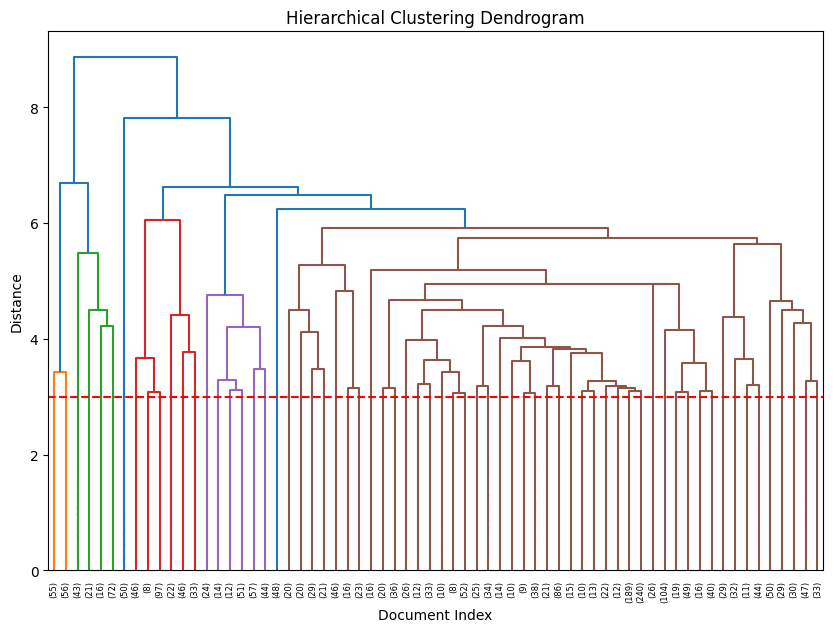

In [28]:
# Assuming you have already generated the linkage matrix Z
Z = linkage(train_dtm.toarray(), method='ward')

# Plotting the dendrogram
plt.figure(figsize=(10, 7))
plt.title('Hierarchical Clustering Dendrogram')

# Plot the full dendrogram
dendrogram(Z, truncate_mode='lastp', p=66, show_contracted=True)

# Draw a horizontal line to show the cut point for 66 clusters
plt.axhline(y=Z[-66, 2], color='r', linestyle='--')

plt.xlabel('Document Index')
plt.ylabel('Distance')
plt.show()

### Conclusion

**Conclusion:**

The question I proposed was twofold. Could the clusters be organized in a meanigful way? The answer to that is yes.

Secondly, what can we learn about the data/documents?

We can actually learn quite a bit about the documents. By clustering the documents together based on TF-IDF, we can learn about authors writing styles and genres. We can also discover similarity between documents, in terms of thier content- which can be very Specific! Just look at the some of the clusters I highlighted above in analysis!

Now, to my stakeholder friends, how might this be intresting to you?

Firstly, if we apply similar clustering to an even wider variety of documents and include current day documents, we can discover trends in the news regarding markets, international affairs, and much more. You my friend would have up to date information about the business world, which in turn would help you decide what markets, trends, companies, etc to investigate for possible investements.

If there is an economist, investor, CEO, or Company we want to keep track of, this clustering would also help us do that. Perhaps we want to keep tabs on Middle East Oil, or General Motors, to understand what is happening within those companies. Or we want opionons from a trusted economist regarding the current economy.

I have also included an image containing the 66 clusters established in the 'results' section. By looking at the color and heights of the clusters, we can determine their similarities as well. With this model there are visual tools like this graph as well, which make the data clear and easy to read.

The tool I have created is a fantastic and efficient way to organize and understand data. This information could be essential for your decision making.

Thank you.



# **IGNORE**

*(This down here did not work, but kept code for review in future or for fixing)*

## Find Common Words Across Clusters

In [15]:
from collections import defaultdict

def find_common_words_across_clusters(cluster_labels, texts, top_n=10):
    cluster_top_words = {}
    word_cluster_map = defaultdict(list)

    # Get top words for each cluster
    for cluster_num in set(cluster_labels):
        top_words = get_top_words_in_cluster(cluster_labels, cluster_num, texts, top_n=top_n)
        cluster_top_words[cluster_num] = top_words
        for word, _ in top_words:
            word_cluster_map[word].append(cluster_num)

    # Print common words across multiple clusters
    for word, clusters in word_cluster_map.items():
        if len(clusters) > 1:  # Word appears in more than one cluster
            print(f"Word '{word}' appears in clusters {clusters}")


## Analyze Clusters by Author

In [12]:
from collections import defaultdict

def analyze_clusters_by_authors(cluster_labels, cluster_num, authors, texts):
    author_docs = defaultdict(list)

    # Group documents by author within the cluster
    for i in range(len(cluster_labels)):
        if cluster_labels[i] == cluster_num:
            author_docs[authors[i]].append(texts[i])

    # Analyze the authors' contributions
    for author, docs in author_docs.items():
        print(f"Author {author} contributed {len(docs)} documents to Cluster {cluster_num}.")
        top_words = get_top_words_in_cluster(cluster_labels, cluster_num, docs, top_n=10)
        print(f"Top words for author {author} in Cluster {cluster_num}: {top_words}")

# Example usage for a specific cluster
analyze_clusters_by_authors(cluster_labels, 50, train_labels, train_texts)


Author RogerFillion contributed 4 documents to Cluster 50.


IndexError: list index out of range